## Subsurface temperature and salinity along the float tracks

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cmocean
import gsw

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [ ]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

In [2]:
import imp
import src.importData as imports
import src.calc as calc
import src.interpolation as interp
import src.plots as plots
import src.settings as settings
import src.concat as ct
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter1_manuscript', 'revision_figures')

In [7]:
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [8]:
abs_vels = {}
rot_vels = {}

datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
                       
for floatid in floatids:
    #absolute velocities
    file = os.path.join(datadir, 'absolute_velocity', 'by_profile', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_vels[floatid] = xr.open_dataset(file)
    
    #rotated velocities
    file = os.path.join(datadir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)

In [9]:
ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'profile')
ds_dist = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'distance', rot_vels = rot_vels)

In [10]:
CT, SA = {}, {}
CT_even, SA_even = {}, {}
mld = {}
pdens_even_d = {}
mld_even_d = {}

imp.reload(calc)
for floatid in floatids:
    # sub-inertial temperature and salinity
    CT[floatid], SA[floatid] = ds_dist[floatid].CT.interpolate_na(dim = 'distance', max_gap = 9), ds_dist[floatid].SA.interpolate_na(dim = 'distance', max_gap = 9)
    mld[floatid] = calc.MLD_float(ds_dist[floatid], floatid, plot = False)
    
    CT_even[floatid] = interp.even_dist_grid(CT[floatid], 3)
    SA_even[floatid] = interp.even_dist_grid(SA[floatid], 3)

    pdens_even_d[floatid] = calc.potentialDensity(CT_even[floatid].pressure, SA_even[floatid], CT_even[floatid])
    mld_even_d[floatid] = calc.MLD(pdens_even_d[floatid], criteria = 0.05, pref = 10)
    

In [11]:
levels = np.arange(26.9,27.9,0.2)

In [12]:
locs = {}
locs[8489] = [180,220]
locs[8492] = [220,310]
locs[8493] = [260,330]

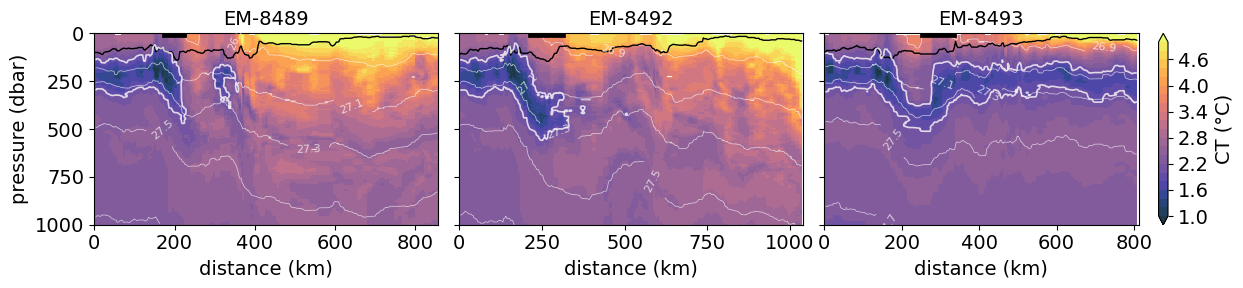

In [13]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = CT_even[floatid].plot(ax = axs[i], x = 'distance',  cmap = cmocean.cm.thermal, levels = np.arange(1, 5.2, 0.2),
                                           alpha = 0.9, add_colorbar = False)
    
    mld_even_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = pdens_even_d[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'w', linewidths = 0.5, 
                                            levels = levels, alpha = 0.7)
    
    isotherm = np.arange(2,2.05,0.1)
    CT_even[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'snow', linewidths = 1.2, alpha = 0.8,
                             levels = isotherm, linestyles = 'solid', zorder = 3)

    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1000)
    
    
    # plot float locations (black dots) at the top of the figure
    d1, d2 = locs[floatid][0], locs[floatid][1]
    d = CT_even[floatid].distance.sel(distance = slice(d1,d2))
    axs[i].plot(d, 0*np.arange(0, len(d)), c = 'k', linewidth = 7, zorder = 5)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'CT (°C)', extend = 'both')

In [14]:
# settings.save_figure(fig, my_path, 'CT_marked.png', dpi = 600, pad = 0.2)

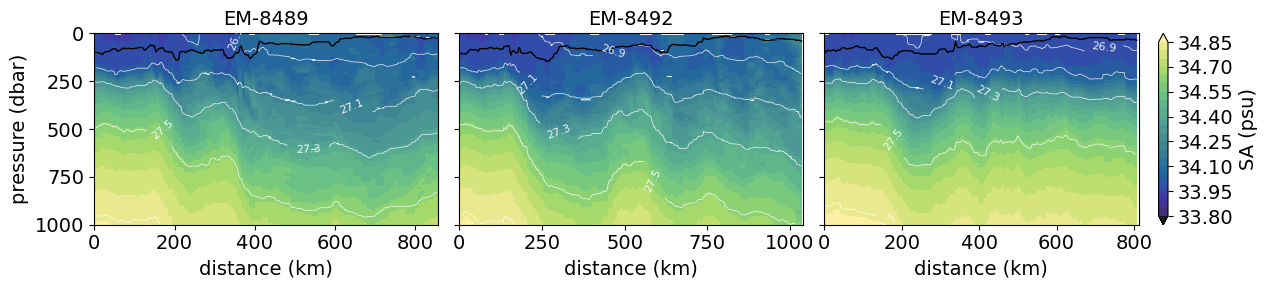

In [15]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = SA_even[floatid].plot(ax = axs[i], x = 'distance',  cmap = cmocean.cm.haline, alpha = 0.9,
                                            levels = np.arange(33.8, 34.85, 0.05), add_colorbar = False)
    
    mld_even_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = pdens_even_d[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'w', linewidths = 0.5, 
                                            levels = levels, alpha = 0.9)
    
#     isohaline = np.arange(34.2,34.25,0.1)
#     SA_even[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'snow', linewidths = 1.2, alpha = 0.8,
#                              levels = isohaline, linestyles = 'solid', zorder = 3)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1000)
    
#     # plot float locations (black dots) at the top of the figure
#     d1, d2 = locs[floatid][0], locs[floatid][1]
#     d = SA_even[floatid].distance.sel(distance = slice(d1,d2))
#     axs[i].plot(d, 0*np.arange(0, len(d)), c = 'k', linewidth = 7)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'SA (psu)', extend = 'both')

In [16]:
# settings.save_figure(fig, my_path, 'SA.png', dpi = 600, pad = 0.2)

In [17]:
floatid = 8492
rs = calc.findRSperiod(ema[floatid])

Text(0.5, 1.0, 'evely gridded in distance')

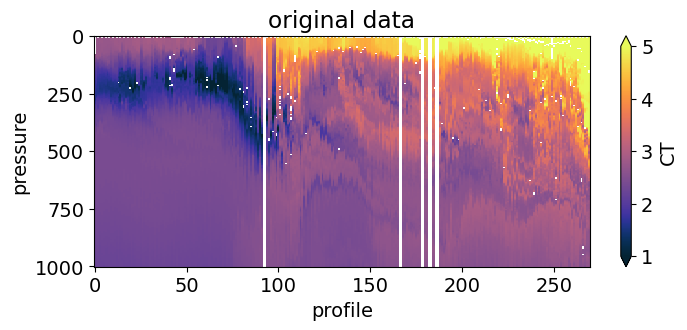

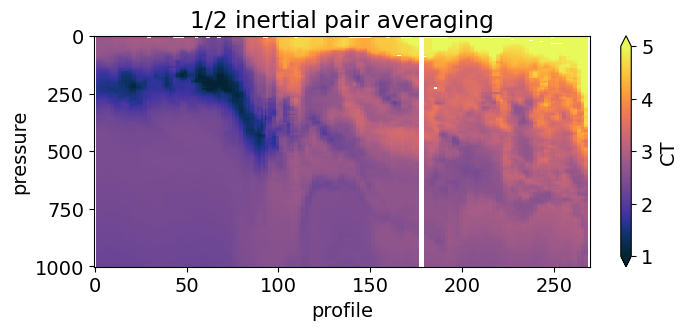

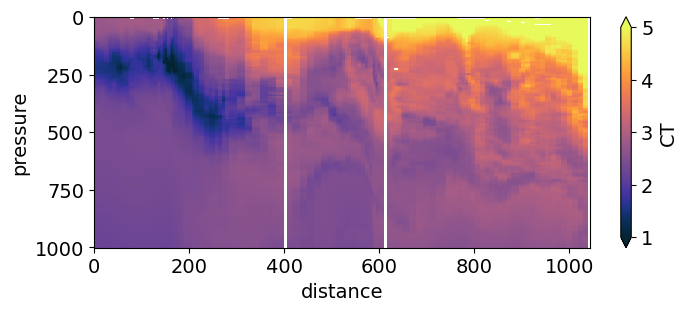

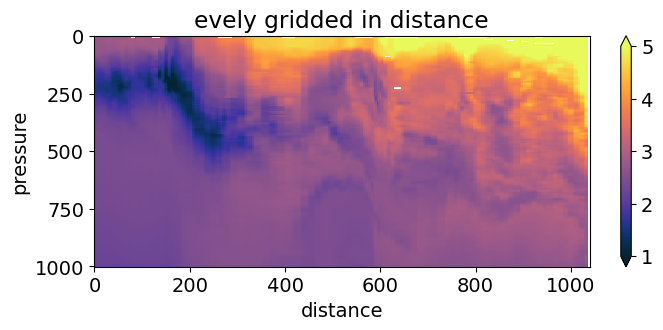

In [18]:
fig, ax = plt.subplots(figsize = (8,3))
ema[floatid].CT[rs].sel(pressure = slice(0,1000)).plot(x = 'profile', vmin = 1, vmax = 5, cmap = cmocean.cm.thermal, 
                                                              cbar_kwargs = dict(label = 'CT'))
ax.invert_yaxis()
ax.set_ylabel('pressure')
plt.title('original data')

# 1/2 inertial pair averaged data - plotted by profile
fig, ax = plt.subplots(figsize = (8,3))
ds[floatid].CT.sel(pressure = slice(0,1000)).plot(x = 'profile', vmin = 1, vmax = 5, cmap = cmocean.cm.thermal)
ax.invert_yaxis()
plt.title('1/2 inertial pair averaging')

# plotted by distance
fig, ax = plt.subplots(figsize = (8,3))
ds_dist[floatid].CT.sel(pressure = slice(0,1000)).plot(x = 'distance', vmin = 1, vmax = 5, cmap = cmocean.cm.thermal)
ax.invert_yaxis()

# evenly gridded in distance
fig, ax = plt.subplots(figsize = (8,3))
CT_even[floatid].sel(pressure = slice(0,1000)).plot(x = 'distance', vmin = 1, vmax = 5, cmap = cmocean.cm.thermal)
ax.invert_yaxis()
plt.title('evely gridded in distance')

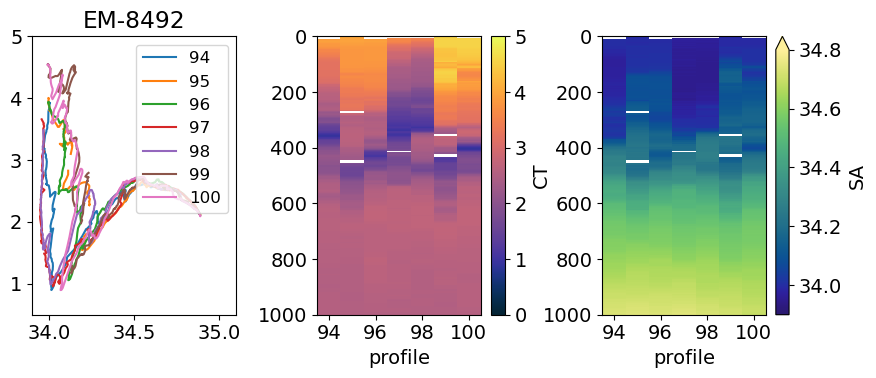

In [19]:
prof1, prof2 = 94,101
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,4))

for i in np.arange(prof1, prof2, 1):
    ax1.plot(ema[floatid].SA[i], ema[floatid].CT[i])
    
ax1.legend(np.arange(prof1, prof2, 1), fontsize = 12, 
                                   loc = 'upper right')
ax1.set_title('EM-8492')
ax1.set_xlim(33.9, 35.1)
ax1.set_ylim(0.5, 5)

ema[floatid].CT.sel(profile = slice(prof1, prof2)).plot(ax = ax2, x = 'profile', vmin = 0, vmax = 5, 
                                                        cmap = cmocean.cm.thermal, cbar_kwargs = dict(label = 'CT'))
ax2.set_ylim(0, 1000)
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, prof2-prof1, 2))
ax2.set_xticklabels(np.arange(prof1, prof2+1, 2))
ax2.set_ylabel('')

ema[floatid].SA.sel(profile = slice(prof1, prof2)).plot(ax = ax3, vmin = 33.9, vmax = 34.8, cmap = cmocean.cm.haline, 
                                                        x = 'profile', cbar_kwargs = dict(label = 'SA'))
ax3.set_ylim(0, 1000)
ax3.invert_yaxis()
ax3.set_xticks(np.arange(0, prof2-prof1, 2))
ax3.set_xticklabels(np.arange(prof1, prof2+1, 2))
ax3.set_ylabel('')

plt.tight_layout(w_pad = -0.5)

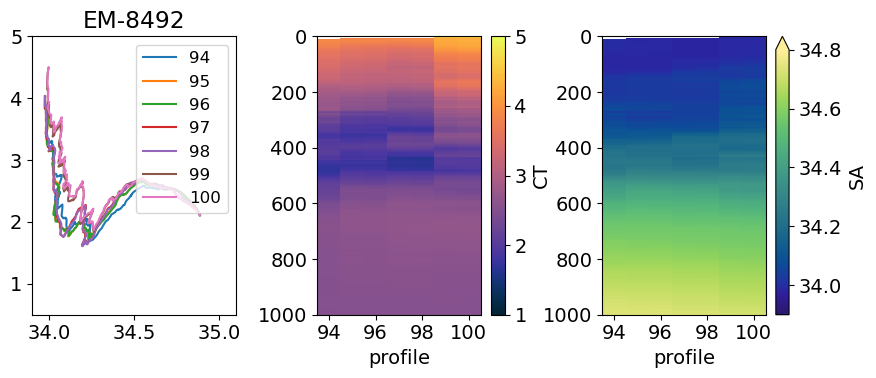

In [20]:
prof1, prof2 = 94,101
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,4))

for i in np.arange(prof1, prof2, 1):
    ax1.plot(ds[floatid].SA[i], ds[floatid].CT[i])
    
ax1.legend(np.arange(prof1, prof2, 1), fontsize = 12, 
                                   loc = 'upper right')
ax1.set_title('EM-8492')
ax1.set_xlim(33.9, 35.1)
ax1.set_ylim(0.5, 5)

ds[floatid].CT.sel(profile = slice(prof1, prof2)).plot(ax = ax2, vmin = 1, vmax = 5, cmap = cmocean.cm.thermal, x = 'profile')
ax2.set_ylim(0, 1000)
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, prof2-prof1, 2))
ax2.set_xticklabels(np.arange(prof1, prof2+1, 2))
ax2.set_ylabel('')

ds[floatid].SA.sel(profile = slice(prof1, prof2)).plot(ax = ax3, vmin = 33.9, vmax = 34.8, cmap = cmocean.cm.haline, x = 'profile')
ax3.set_ylim(0, 1000)
ax3.invert_yaxis()
ax3.set_xticks(np.arange(0, prof2-prof1, 2))
ax3.set_xticklabels(np.arange(prof1, prof2+1, 2))
ax3.set_ylabel('')

plt.tight_layout(w_pad = -0.5)

### Mixed layer depth (MLD)

In [25]:
mld_subinertial = {}
mld_og = {}

for floatid in floatids:
    #original dataset
    d = settings.distanceAsCoord(ema[floatid], rs = True)
    dens = calc.potentialDensity(d.pressure, d.SA, d.CT)
    mld_og[floatid] = calc.MLD(dens, criteria = 0.05, pref = 10)
    
    # subinterital dataset
    dens = calc.potentialDensity(ds_dist[floatid].pressure, ds_dist[floatid].SA, ds_dist[floatid].CT)
    mld_subinertial[floatid] = calc.MLD(dens, criteria = 0.05, pref = 10)

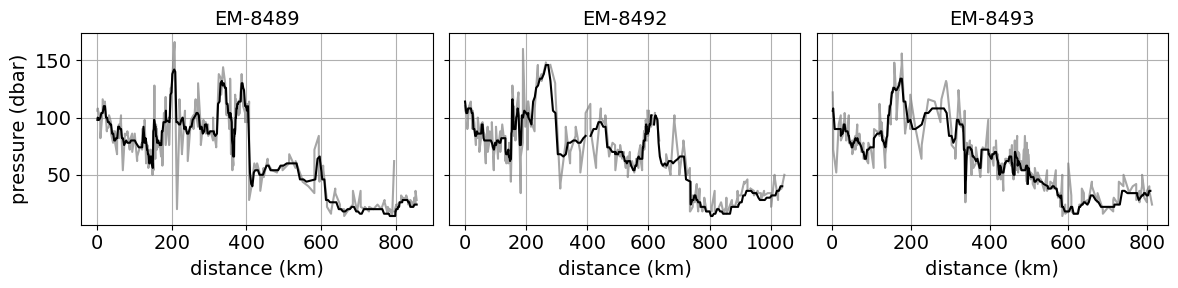

In [33]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    mld_og[floatid].plot(ax = axs[i], c = 'grey', alpha = 0.7)
    mld_subinertial[floatid].plot(ax = axs[i], c = 'k')

    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].grid()
    
    i+=1

axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.5)

Text(0.5, 1.0, '750-1050 km')

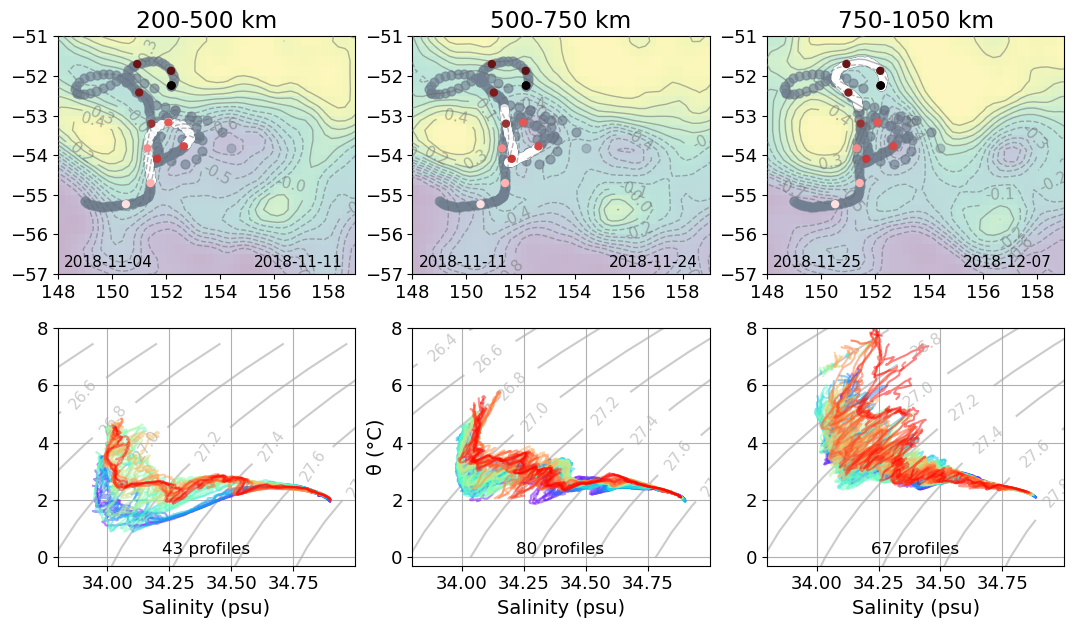

In [35]:
imp.reload(plots)

floatid = 8492
float_num = ema[floatid]
dist = calc.cum_dist(float_num.longitude, float_num.latitude)

st, a, b, c = 200, 500, 750, 1050

sections = [slice(np.where(dist <= st)[0][-1]+1,np.where(dist <= a)[0][-1]), slice(np.where(dist <= a)[0][-1]+1, np.where(dist <= b)[0][-1]), 
            slice(np.where(dist <= b)[0][-1]+1, np.where(dist <= c)[0][-1])]

imp.reload(plots)
axs = plots.trajectory_sections_and_TS(ema, [floatid], sections, alt_cmems)
axs[0].set_title(f'{st}-{a} km')
axs[1].set_title(f'{a}-{b} km')
axs[2].set_title(f'{b}-{c} km')

In [36]:
ind = np.where(np.logical_and(dist < 450, dist > 400))[0]
section = slice(ind[0], ind[-1])

In [37]:
print(f'erroneous profile: {ind[0]}')
print('distance: {}'.format(dist[ind[0]].values))

erroneous profile: 109
distance: 410.14644049901125


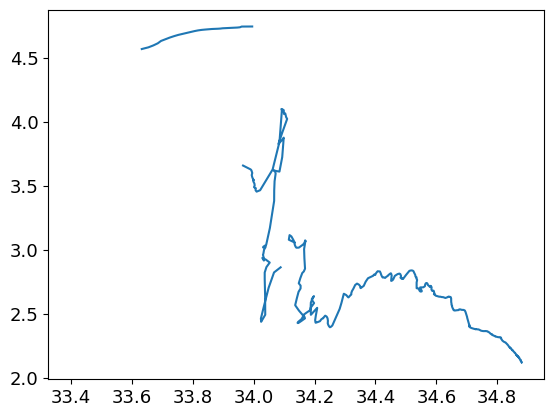

In [38]:
plt.plot(float_num.SA[ind[0]], float_num.CT[ind[0]])

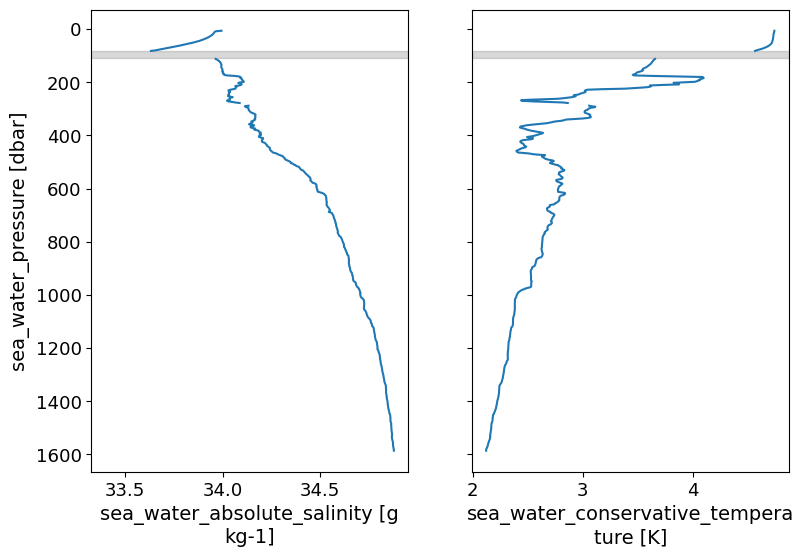

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (9,6))
float_num.SA[ind[0]].plot(ax = ax1, y = 'pressure')
float_num.CT[ind[0]].plot(ax = ax2, y = 'pressure')
ax1.invert_yaxis()
ax2.set_ylabel('')
ax1.axhspan(84, 110, color = 'grey', alpha = 0.3)
ax2.axhspan(84, 110, color = 'grey', alpha = 0.3)

In [40]:
# missing values where the large jump in T and S occurs between 84 and 110 m depth.

Text(0.5, 1.0, '600-840 km')

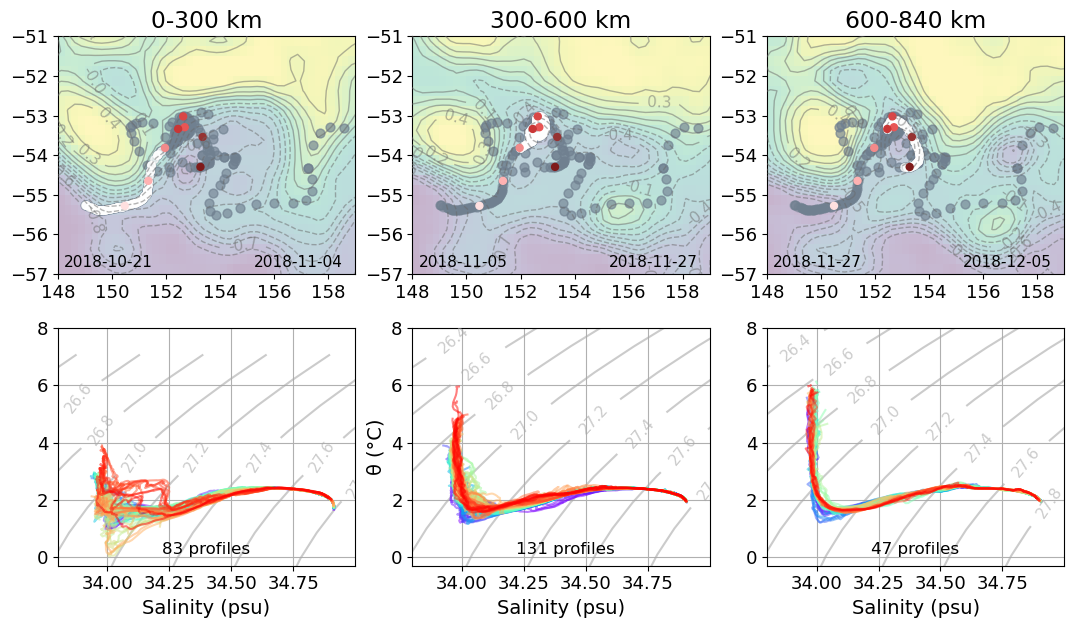

In [41]:
floatid = 8493
float_num = ema[floatid]
dist = calc.cum_dist(float_num.longitude, float_num.latitude)

st, a, b, c = 0, 300, 600, 840

sections = [slice(np.where(dist <= st)[0][-1]+1,np.where(dist <= a)[0][-1]), slice(np.where(dist <= a)[0][-1]+1, np.where(dist <= b)[0][-1]), 
            slice(np.where(dist <= b)[0][-1]+1, np.where(dist <= c)[0][-1])]

imp.reload(plots)
axs = plots.trajectory_sections_and_TS(ema, [floatid], sections, alt_cmems)
axs[0].set_title(f'{st}-{a} km')
axs[1].set_title(f'{a}-{b} km')
axs[2].set_title(f'{b}-{c} km')

In [42]:
def T_S(float_num, floatid, section, alt_cmems, pcolor_ds, p_range = slice(0,1600), **kwargs):
    lonmin, lonmax = 148, 155
    latmin, latmax = -57, -51
    levels = np.arange(-0.8,0.4,0.1)

    fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (10,4))
    axs = axs.flatten()

    start = float_num.time.values[section][0]
    end = float_num.time.values[section][-1]
    start_time, end_time = str(start.astype('M8[D]')), str(end.astype('M8[D]'))

    # mean sea level during float section
    msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')
    mean_field = pcolor_ds.sel(time = slice(start_time, end_time)).mean(dim = 'time')
    
    im = mean_field.sel(longitude = slice(lonmin, lonmax), latitude = slice(latmin, latmax)).plot(ax = axs[0], 
                                                                        **kwargs,add_colorbar=False)

    CS = msl.plot.contour(ax = axs[0], colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = levels, zorder = 3)
    plt.clabel(CS, inline=True, fontsize=11, fmt = '%1.1f')

    # Float trajectory map with points coloured in acccording to time slice
    axs[0].scatter(float_num.longitude, float_num.latitude, s = 50, c= 'slategrey',zorder = 2, alpha = 0.4)
    axs[0].scatter(float_num.longitude[section], float_num.latitude[section], s = 48, c='w', zorder = 2, alpha = 0.7)
    
    axs[0].text(0.03, 0.03, f'{start_time}', transform = axs[0].transAxes)
    axs[0].text(0.67, 0.03, f'{end_time}', transform = axs[0].transAxes)
    
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
#     axs[0].set_title(floatid)

    # T-S diagram
    CT, SA = settings.remove_bad_T_S(float_num, floatid)
        
    sal = SA[section].sel(pressure = p_range) #.sel(pressure = slice(150,300))
    temp = CT[section].sel(pressure = p_range) #.sel(pressure = slice(150,300))
    ti, si, dens = calc.tsDensContour(sal, temp)
    n = len(sal)
    colors = plt.cm.rainbow(np.linspace(0,1,n))

    for k in range(n):
        im = axs[1].plot(sal[k], temp[k], color=colors[k], alpha = 0.7)

    # add density contours
    CS = axs[1].contour(si, ti, dens, levels = np.arange(26.4, 27.9, 0.2), colors='darkgrey', alpha = 0.7)
    plt.clabel(CS, inline=1, fontsize=12, fmt = '%1.1f')
    
    axs[1].set_ylim(0.5,8)
    axs[1].set_xlim(33.75,35)
#     axs[1].set_title(floatid)
    
    axs[1].text(0.35, 0.05,'{} profiles'.format(n),transform=axs[1].transAxes)
    

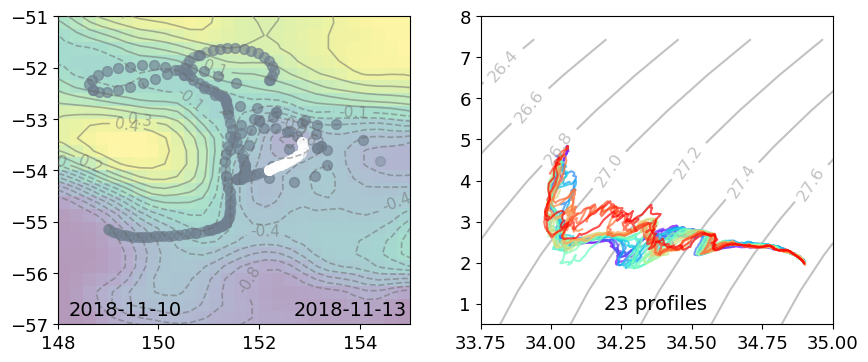

In [43]:
floatid = 8492
float_num = ema[floatid]
dist = calc.cum_dist(float_num.longitude, float_num.latitude)
st, en = 450, 550

section = slice(np.where(dist <= st)[0][-1]+1,np.where(dist <= en)[0][-1])

T_S(float_num, floatid, section, alt_cmems, alt_cmems.adt, cmap = 'viridis', vmin = -1, vmax = 0.5,
                                        alpha = 0.4, p_range = slice(0,1600))

### T, S, U & V full sections

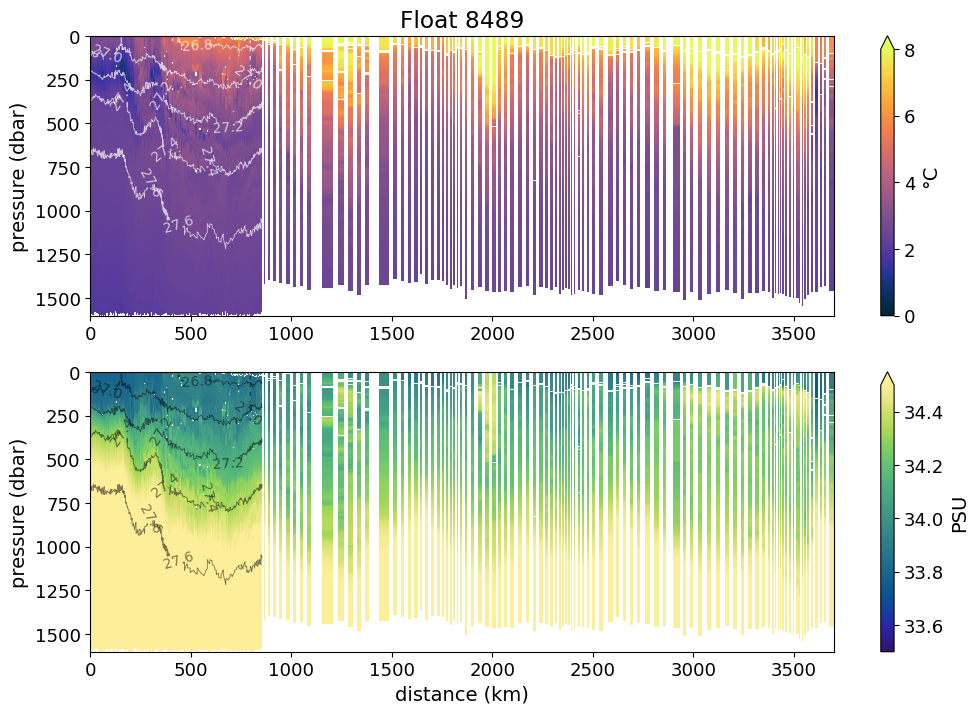

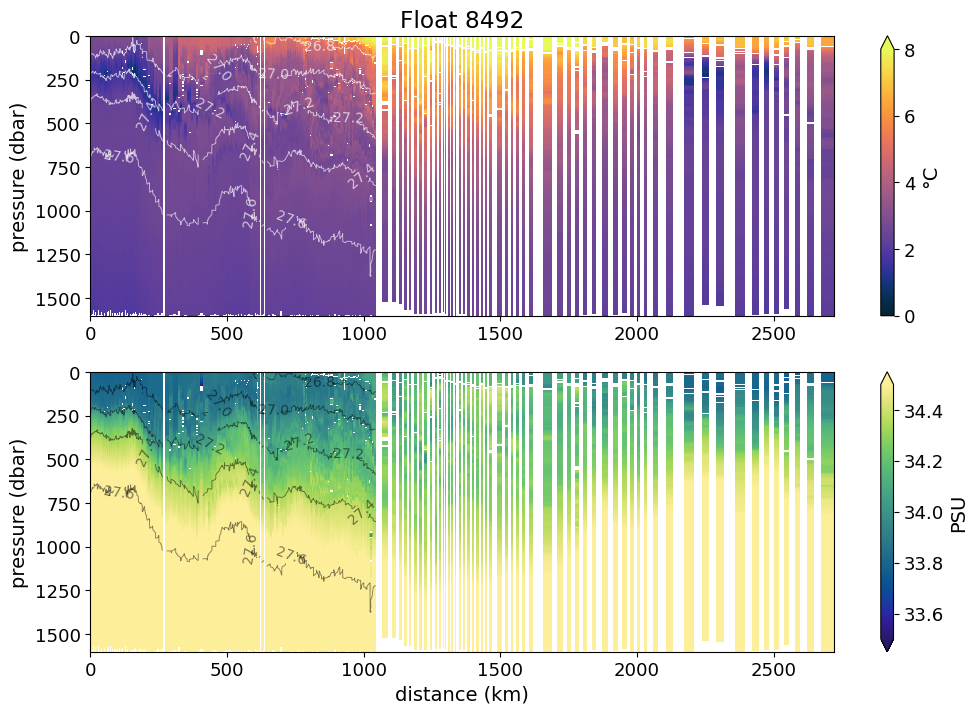

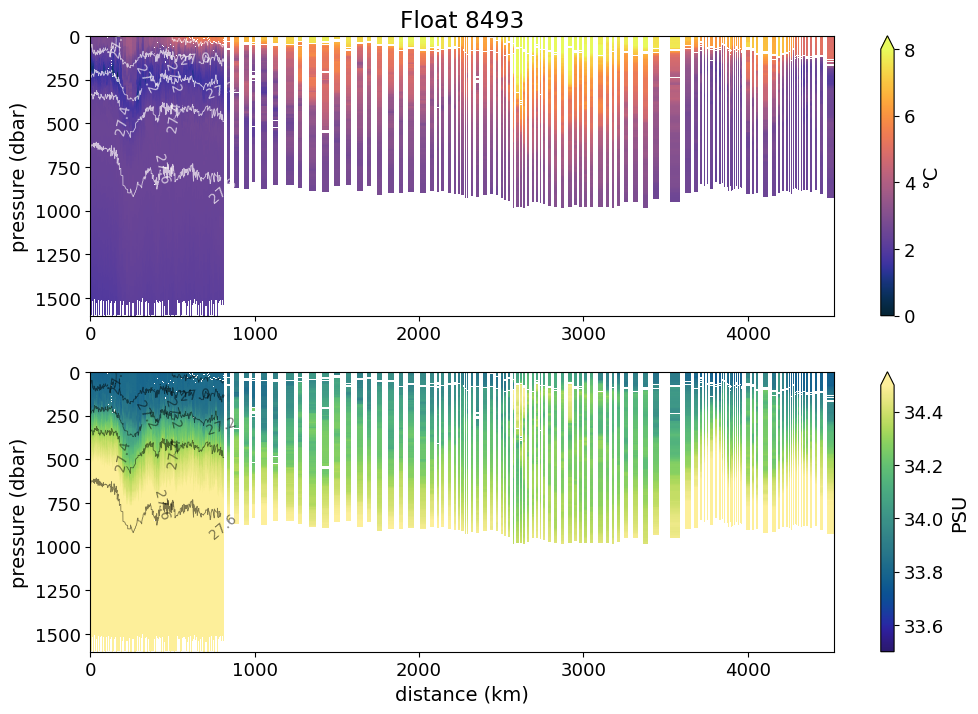

In [44]:
imp.reload(plots)

floatids = [8489, 8492, 8493]
for floatid in floatids:
    float_num = ema[floatid]
    plots.sectionsOnP(float_num, floatid, TS = True, UV = False, rs = False)